In [1]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
import tensorflow_model_optimization as tfmot
import numpy as np
assert float(tf.__version__[:3]) >= 2.3

## Model loading

In [4]:
from utils.losses import focal_loss
from builders import builder

In [6]:
weights_list = os.listdir(os.path.join(os.getcwd(),'weights'))
weights_list

['UNet_based_on_MobileNetV2_gamma_2.h5',
 'UNet_based_on_MobileNetV2_gamma_5.h5',
 'UNet_based_on_MobileNetV2_CE.h5',
 'UNet_based_on_VGG16_29.h5',
 'UNet_based_on_MobileNetV2_QAT.h5',
 'PAN_based_on_MobileNetV2_29.h5',
 'DeepLabV3Plus_based_on_MobileNetV2_29.h5',
 'metadata',
 'UNet_based_on_MobileNetV2_11.h5',
 'UNet_based_on_MobileNetV2_12.h5',
 'UNet_based_on_MobileNetV2_13.h5',
 'UNet_based_on_MobileNetV2_14.h5',
 'UNet_based_on_MobileNetV2_15.h5',
 'UNet_based_on_MobileNetV2_16.h5',
 'UNet_based_on_MobileNetV2_17.h5',
 'UNet_based_on_MobileNetV2_18.h5',
 'UNet_based_on_MobileNetV2_19.h5']

In [9]:
num_classes = 2
size = (256,256)
batch_size = 2
model_name = 'UNet'
base_model = 'MobileNetV2'

working_dir = os.getcwd()

# model, base_model = builder(num_classes, size, model_name, base_model)
# # 가중치 로드
# model.load_weights(os.path.join(working_dir,'weights',weights_list[1]))

## Model Redefine

In [45]:
layers = tf.keras.layers
input_size = (256,256)

inputs = layers.Input(shape=input_size+(3,))

# 일단은 모델 unet 통과
x = model(inputs)
# outputs = tf.expand_dims(tf.math.argmax(tf.nn.softmax(x,axis=-1),axis=-1,output_type=tf.dtypes.int32),axis=0)
outputs = layers.Dense(num_classes,activation='softmax',dtype=tf.uint8) # 설마 .....마지막 차원이겠지.....

model = tf.keras.Model(inputs=inputs,outputs=outputs)

In [46]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 UNet (Functional)           (None, 256, 256, 2)       12401930  
                                                                 
 tf.nn.softmax_18 (TFOpLambd  (None, 256, 256, 2)      0         
 a)                                                              
                                                                 
Total params: 12,401,930
Trainable params: 12,362,054
Non-trainable params: 39,876
_________________________________________________________________


## Sample Dataloading

In [43]:
from utils.helpers import get_dataset_info
from utils.data_generator import ImageDataGenerator

In [44]:
# data_path = "D://crack data//도로장애물·표면 인지 영상(수도권)//Training//Images//CRACK//data"
data_path = "E:/Training/Images/data"


_, valid_image_names = get_dataset_info(data_path)

image_gen = ImageDataGenerator()

valid_generator = image_gen.flow(images_list=valid_image_names[:10],
                                num_classes=num_classes,
                                batch_size=batch_size,
                                target_size=size
                                )

## TensorFlow Lite 모델로 변환하기

In [47]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\chank\AppData\Local\Temp\tmpdowher3d\assets


INFO:tensorflow:Assets written to: C:\Users\chank\AppData\Local\Temp\tmpdowher3d\assets


### 동적 범위 양차화를 사용하여 변환하기

In [12]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\hci\AppData\Local\Temp\tmpczlqv88r\assets


INFO:tensorflow:Assets written to: C:\Users\hci\AppData\Local\Temp\tmpczlqv88r\assets


### 정수 전용 양자화를 사용하여 변환하기

In [35]:
def representative_data_gen():
  for i, (images,masks) in enumerate(valid_generator):
    if i == 3:
        break
    yield [images.astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\chank\AppData\Local\Temp\tmpn816d72g\assets


INFO:tensorflow:Assets written to: C:\Users\chank\AppData\Local\Temp\tmpn816d72g\assets


In [36]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.int32'>


In [48]:
# 모델 저장
import pathlib

tflite_models_dir = pathlib.Path("./tflite_models/unet_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"unet_tflite_models.tflite"
tflite_model_file.write_bytes(tflite_model)

# # Save the quantized model:
# tflite_model_quant_file = tflite_models_dir/"unet_tflite_quant_models.tflite"
# tflite_model_quant_file.write_bytes(tflite_model_quant)

49401736

## Test

In [4]:
import tensorflow as tf
from utils.losses import dice_coef
from tqdm import tqdm 

In [5]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, batch_data): # 1 batch를 받아옴
  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = []

  images = batch_data[0]
  masks = batch_data[1]
  
  for i in tqdm(range(len(images))): 
    # 각 이미지 로딩
    image = images[i]
    mask = masks[i]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      image = image / input_scale + input_zero_point

    image = np.expand_dims(image,axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions.append(np.argmax(output,axis=-1))

    if i == 0:
      break

  return masks[:,1], predictions

In [ ]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type, data_generator):
    true_masks, predictions = run_tflite_model(tflite_file, data_generator[0]) # 1 batch를 넘겨줌

    dice_score = 0

    for i in range(batch_size):
        dice_score +=dice_coef(true_masks[i],predictions[i].astype(np.float64))
        if i == 0:
            break

    dice_score /= batch_size

    print('%s model dice_score is %.4f%% (Number of test samples=%d)' % (
        model_type, dice_score, batch_size))

In [ ]:
quant_model_path = './tflite_models/unet_tflite_models/unet_tflite_quant_models.tflite'
model_path = './tflite_models/unet_tflite_models/unet_tflite_models.tflite'

print('Quantization model\n')
evaluate_model(quant_model_path,"Quantized",valid_generator)

print('Normal Model\n')
evaluate_model(model_path,"Float",valid_generator)

Quantization model



NameError: name 'valid_generator' is not defined

In [6]:
from tflite_support import metadata

displayer = metadata.MetadataDisplayer.with_model_file("./tflite_models/deeplabv3.tflite")
print("Metadata populated:")
print(displayer.get_metadata_json())

print("Associated file(s) populated:")
for file_name in displayer.get_packed_associated_file_list():
  print("file name: ", file_name)
  print("file content:")
  print(displayer.get_associated_file_buffer(file_name))

Metadata populated:
{
  "name": "DeepLabV3",
  "description": "Semantic image segmentation predicts whether each pixel of an image is associated with a certain class.",
  "version": "v1",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be segmented. The expected image is 257 x 257, with three channels (red, blue, and green) per pixel. Each element in the tensor is a value between -1 and 1.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
        

## Quantization Model
#### 참조사이트
- [훈련 후 정수 양자화](https://www.tensorflow.org/lite/performance/post_training_integer_quant?hl=ko)
- [TensorFlow Lite 8bits 양자화 사양](https://www.tensorflow.org/lite/performance/quantization_spec)
- [딥러닝의 Quantization (양자화)와 Quantization Aware Training](https://gaussian37.github.io/dl-concept-quantization/)

In [2]:
weights_list = os.listdir('./weights/')
weights_list

['UNet_based_on_MobileNetV2_gamma_2.h5',
 'UNet_based_on_MobileNetV2_gamma_5.h5',
 'UNet_based_on_MobileNetV2_CE.h5',
 'UNet_based_on_VGG16_29.h5',
 'UNet_based_on_MobileNetV2_QAT.h5',
 'PAN_based_on_MobileNetV2_29.h5',
 'DeepLabV3Plus_based_on_MobileNetV2_29.h5',
 'UNet_based_on_MobileNetV2_CE_QAT_288384.h5',
 'UNet_based_on_MobileNetV2_CE_QAT_288384_aug.h5',
 'UNet_based_on_MobileNetV2_CE_QAT_288384_50000.h5']

In [5]:
num_classes = 2
size = (288,384)
# size = (256,256)
batch_size = 32
model_name = 'UNet'
base_model = 'MobileNetV2'
layers = tf.keras.layers
inputs = layers.Input(shape=size+(3,),dtype=tf.float32)

working_dir = os.getcwd()

quantize_model = tfmot.quantization.keras.quantize_model

model, base_model = builder(num_classes, size, model_name, base_model)
model = quantize_model(model)

# 가중치 로드
model.load_weights(os.path.join(working_dir,'weights',weights_list[-1]))

x = model(inputs)
outputs = layers.Softmax(axis=-1)(x) 

model = tf.keras.Model(inputs=inputs,outputs=outputs)

c:\Users\hci\anaconda3\envs\tensorflow\lib\site-packages\keras\layers\wrappers.py:64: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  config = {'layer': generic_utils.serialize_keras_object(self.layer)}
c:\Users\hci\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [6]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\hci\AppData\Local\Temp\tmp6ptw2t8p\assets


INFO:tensorflow:Assets written to: C:\Users\hci\AppData\Local\Temp\tmp6ptw2t8p\assets


In [26]:
def representative_data_gen():
  for i, (images,masks) in enumerate(valid_generator):
    if i == 1:
        break
    yield [images.astype(np.float32)] # 여기는 이미 normalization된 상태이다.

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\hci\AppData\Local\Temp\tmpfsdqtu43\assets


INFO:tensorflow:Assets written to: C:\Users\hci\AppData\Local\Temp\tmpfsdqtu43\assets


In [14]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


In [7]:
# 모델 저장
import pathlib

tflite_models_dir = pathlib.Path("./tflite_models/unet_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"unet_tflite_quant_288384_50000_models.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

12931768

## Tensorflow lite Metadata Writer

In [8]:
from tflite_support.metadata_writers import image_segmenter
from tflite_support.metadata_writers import writer_utils

In [12]:
tflite_models_dir = './tflite_models/unet_tflite_models'
tflite_model_list = os.listdir(tflite_models_dir)
tflite_model_list

['unet_tflite_models.tflite',
 'unet_tflite_quant_models.tflite',
 'metadata',
 'unet_tflite_quant_qat_models.tflite',
 'unet_tflite_quant_320480_models.tflite',
 'unet_tflite_quant_288384_models.tflite',
 'unet_tflite_quant_288384_aug_models.tflite',
 'unet_tflite_quant_288384_50000_models.tflite',
 'desktop.ini']

In [13]:
ImageSegmenterWriter = image_segmenter.MetadataWriter
tflite_model_name = tflite_model_list[-2]
_MODEL_PATH = os.path.join(tflite_models_dir,tflite_model_name)

# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = "./label.txt"

model_file_name = "unet_tflite_quant_qat_288384_models_50000_metadata.tflite"
_SAVE_TO_PATH = os.path.join(tflite_models_dir,'metadata',model_file_name)

# Normalization parameters is required when reprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/models/convert/metadata#normalization_and_quantization_parameters)
_INPUT_NORM_MEAN = 127.5
_INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = ImageSegmenterWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD],[_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "ImageSegmenter",
  "description": "Semantic image segmentation predicts whether each pixel of an image is associated with a certain class.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be segmented.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
  

In [19]:
img_list = os.listdir('E:/Training/Images/data')[:10]

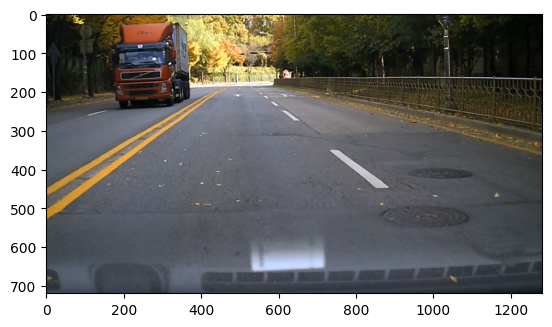

In [38]:
from PIL import Image
from PIL import ImageEnhance
import matplotlib.pyplot as plt

img_path = 'E:/Training/Images/data'

img = Image.open(os.path.join(img_path,img_list[9]))
plt.imshow(img)

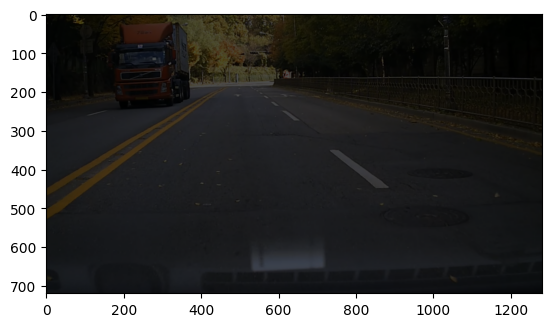

In [55]:
plt.imshow(ImageEnhance.Brightness(img).enhance(0.3))